In [5]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
import tensorflow_probability as tfp
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import pickle
from functools import partial
from tqdm import tqdm_notebook as tqdm


from models import DeepConditionalModel, InvariantNetwork
from losses import maximum_likelihood_loss
from inn_utils import train_online_ml

In [6]:
np.set_printoptions(suppress=True)

In [7]:
plt.rcParams['font.size'] = 14

In [8]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
tf.enable_eager_execution()

# GMM Example

In [18]:
def mixture_of_gaussians(batch_size, one_hot=True):
    
    indices = np.random.choice(np.random.permutation(8), size=batch_size, replace=True)
    samples = np.array([np.random.multivariate_normal(means[idx], np.identity(2)/2) for idx in indices])
    indices[indices==0] = 0
    indices[indices==1] = 0
    indices[indices==2] = 0
    indices[indices==3] = 0
    indices[indices==4] = 1
    indices[indices==5] = 1
    indices[indices==6] = 2
    indices[indices==7] = 3
    if one_hot:
        indices = tf.keras.utils.to_categorical(indices, num_classes=4)
    
    return tf.convert_to_tensor(indices, dtype=tf.float32), tf.convert_to_tensor(samples, dtype=tf.float32)


def visualize_gmm(ax, model=None, n_samples_posterior=1000, title="Default"):
    """
    Plots samples from a GMM on a given axis.
    """
    
    if model is not None:
        X_test = tf.keras.utils.to_categorical(np.array([0, 1, 2, 3]))
        samples_theta = model.sample(X_test, n_samples_posterior).numpy()

        samples_theta_x1 = np.concatenate([
            samples_theta[:, 0, 0],
            samples_theta[:, 1, 0],
            samples_theta[:, 2, 0],
            samples_theta[:, 3, 0],
        ])

        samples_theta_x2 = np.concatenate([
            samples_theta[:, 0, 1],
            samples_theta[:, 1, 1],
            samples_theta[:, 2, 1],
            samples_theta[:, 3, 1],
        ])
        idx = np.repeat([0, 1, 2, 3], n_samples_posterior)
    else:
        idx, theta_test = mixture_of_gaussians(n_samples_posterior * 8)
        idx = tf.argmax(idx, axis=1)
        samples_theta_x1 = theta_test[:, 0]
        samples_theta_x2 = theta_test[:, 1]
        
    colormap = np.array(['#b35454', '#3e7a3f', '#325599', '#ada623'])
    ax.scatter(samples_theta_x1, samples_theta_x2, c=colormap[idx], alpha=0.5)
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    ax.set_title(title)

In [11]:
def load_model_and_opt(n_inv_blocks, global_step):
    """Loads a GMM model given the number of invertible blocks."""
    
    # Create model
    model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=None, permute=True)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Checkpoint model
    checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
    manager = tf.train.CheckpointManager(checkpoint, './checkpoints/gmm_{}'.format(n_inv_blocks), max_to_keep=2)
    checkpoint.restore(manager.latest_checkpoint)
    
    return model, optimizer, manager


def train_model(n_inv_blocks):
    """
    Runs the GMM for different numbers of n_inv_blocks.
    """
    
    model, optimizer, manager = load_model_and_opt(n_inv_blocks, global_step)
    
    for ep in range(1, epochs+1):
        with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:

            # Run training loop
            train_online_ml(model, optimizer, mixture_of_gaussians, iterations_per_epoch, 
                            batch_size, p_bar=p_bar, clip_value=clip_value, global_step=global_step, 
                            transform=None, n_smooth=100)
            
            manager.save()

In [13]:
# --- GMM settings --- #
means = []
angles = np.linspace(0, 315, 8)
for angle in angles:
    theta = np.radians(angle)
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,-s), (s, c))).T
    means.append(R @ np.array([0, 1]))
means = np.array(means) * 7.5


# --- INN settings --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.0,
    'initializer': 'glorot_uniform'
}
n_inv_blocks = [1, 2, 3, 4, 5]
theta_dim = 2
params_names = [r'$\mu_{}$'.format(i+1) for i in range(theta_dim)]
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 128
epochs = 50
iterations_per_epoch = 1000
n_samples_posterior = 2000
starter_learning_rate = 0.001
decay_steps = 1000
decay_rate = .99
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)

## Train models

In [27]:
# for n_inv in n_inv_blocks:
#     print('Training with ', n_inv, 'blocks...')
#     train_model(n_inv)

## Visualize performance

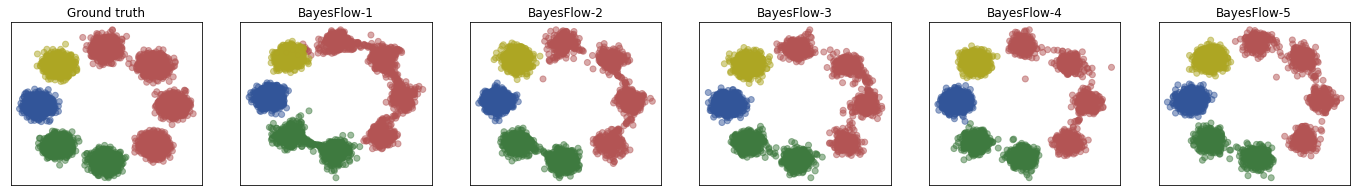

In [29]:
np.random.seed(42)

f, axarr = plt.subplots(1, 6, figsize=(24, 3))

# Plot GMM
visualize_gmm(axarr[0], title="Ground truth")

# Plot Inv 1 ACB
model, _, _ = load_model_and_opt(1, global_step)
visualize_gmm(axarr[1], model, title="BayesFlow-1")

# Plot Inv 2 ACB
model, _, _ = load_model_and_opt(2, global_step)
visualize_gmm(axarr[2], model, title="BayesFlow-2")

# Plot Inv 3 ACB
model, _, _ = load_model_and_opt(3, global_step)
visualize_gmm(axarr[3], model, title="BayesFlow-3")

# Plot Inv 4 ACB
model, _, _ = load_model_and_opt(4, global_step)
visualize_gmm(axarr[4], model, title="BayesFlow-4")

# Plot Inv 5 ACB
model, _, _ = load_model_and_opt(5, global_step)
visualize_gmm(axarr[5], model, title="BayesFlow-5")

f.savefig("figures/GMM.png", dpi=600, bbox_inches='tight')